### Google colab use

Only run the cell below if you are on google colab. This will install opyrability on the google colab session to perform the uncertainty mapping. The kernel will be restarted and you might get a message "Your session crashed for an unknown reason.". You can safely disregard it and continue running the other cells.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c codes-group -c conda-forge opyrability

### Imports

In [2]:
from jax import config
config.update("jax_enable_x64", True)
import jax.numpy as np
import matplotlib.pyplot as plt

# CSTR Example

$A \longrightarrow B$, \
with $-rA = k_1 C_a$, and \
$A \longrightarrow C$ with \
$-rA = k_2 C_a^2$. \
Let the volume of the CSTR be 1, \
with a volumetric flow of $1 L / min$ of $1 M C_a$.
Let $k_1 = 3$, and $k_2 = 2$.

$$ 0 = Fa0 - Fa + rA * V $$
$$= Fa_0 - v_0 * Ca - (k_1 Ca + k_2 * Ca^{2}) * V$$

Some rearrangement there leads to:

$$k_2 Ca^{2} + (v_0 / V + k_1) Ca - Fa_0 / V = 0$$
    
which we can solve with the quadratic equation to get $C_a$.

Then a mole balance on B yields:

$$0 = -Fb + k_1 Ca V$$
$$Cb = k_1 Ca V / v_0$$
    
So we can readily compute Ca and Cb. We do that here. This gives us an initial solution.

# A path describing the uncertainty
Using the parametric equations for defining an ellipse in $\mathbb{R^2}$

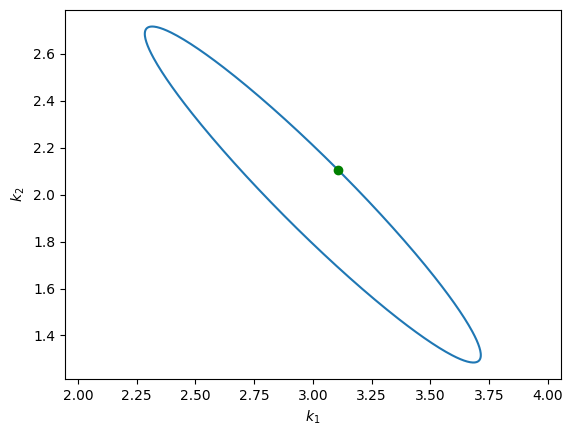

In [3]:
k1, k2 = 3, 2
v0 = V = Ca0 = 1
Fa0 = Ca0 * v0

theta = np.linspace(0, 2 * np.pi, 400)
phi = np.pi / 4
a, b= 0.15, 1


y1 = k1 +  (a * np.cos(theta) * np.cos(phi) - b * np.sin(theta) * np.sin(phi))
y2 = k2 +  (b * np.sin(theta) * np.cos(phi) + a * np.cos(theta) * np.cos(phi))

plt.plot(y1, y2)
plt.plot(y1[0], y2[0], 'go')
plt.xlabel('$k_1$')
plt.ylabel('$k_2$')
plt.axis('equal');

## Analytical solution


Ca_0 = 0.2189527704829274, Cb_0=0.6800817597639911


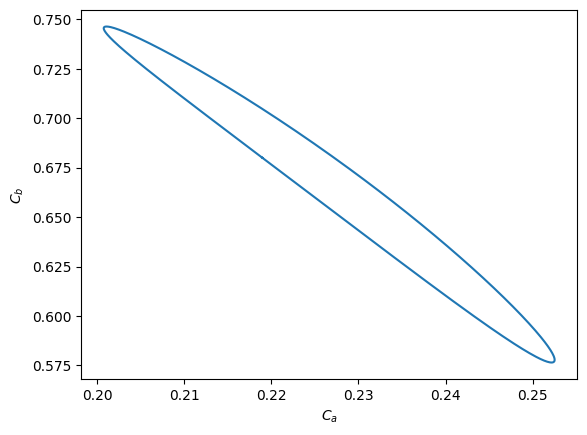

In [4]:
a, b, c = y2, (v0 / V + y1), -Fa0 / V

aCa = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
aCb = y1 * aCa * V / v0
plt.plot(aCa, aCb);
plt.xlabel('$C_a$')
plt.ylabel('$C_b$');

print(f'Ca_0 = {aCa[0]}, Cb_0={aCb[0]}')

## Uncertainty mapping using differentiable programing through opyrability


In [5]:
from opyrability import implicit_map

Defining a starting point from the analytical solution.

In [6]:
AIS_points = np.array([y1,y2]).T

output_init = np.array([aCa[0], aCb[0]])

Forward Mapping Selected.
The given domain is recognized as an Available Input Set (AIS).
The result of this mapping is an Achievable Output Set(AOS)
Selected Euler


100%|██████████| 400/400 [00:36<00:00, 10.82it/s]


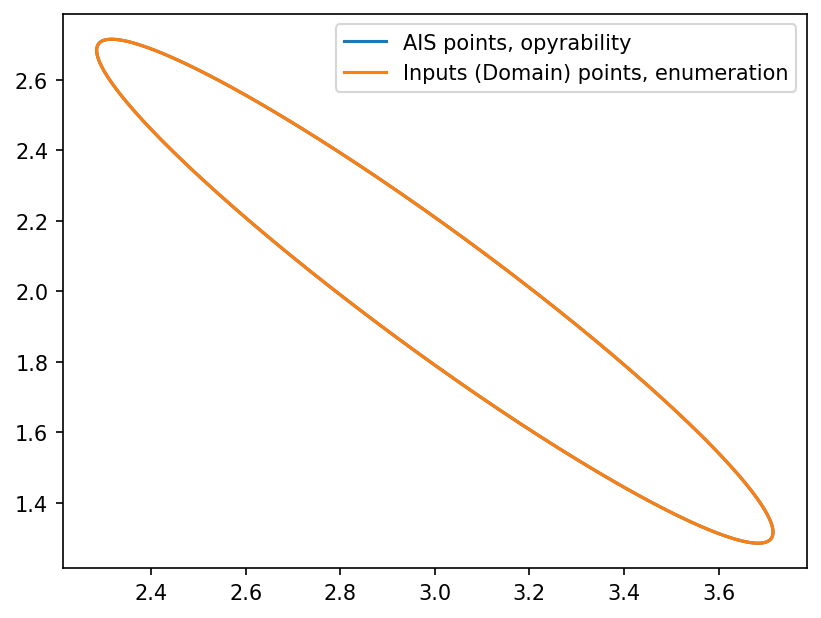

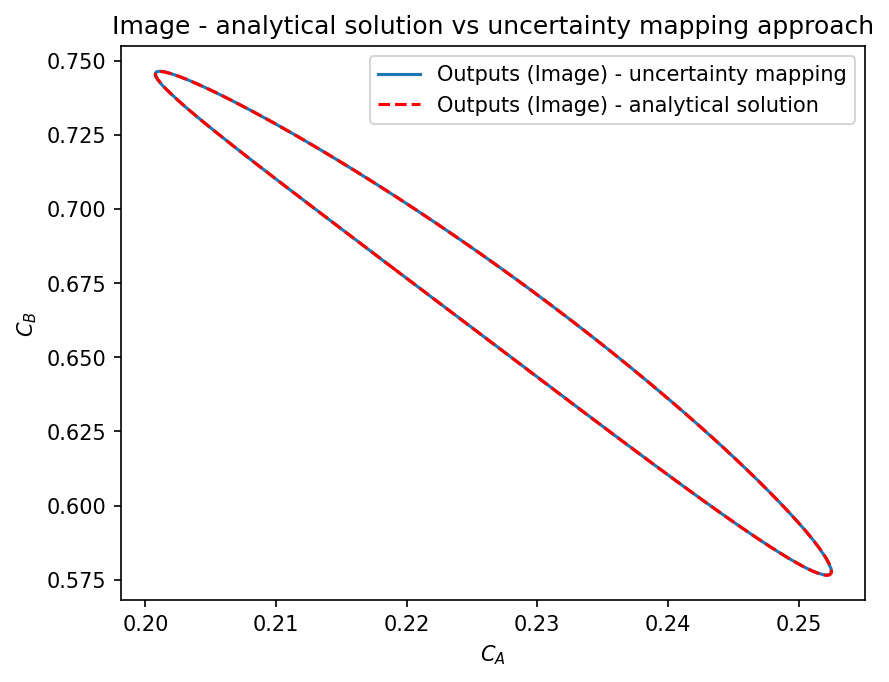

In [7]:
def implicit_function(k, C):
    k1 = k[0]
    k2 = k[1]
    Ca = C[0]
    Cb = C[1]

    z1 = Fa0 - Ca * v0 - (k1 * Ca + k2 * Ca**2) * V
    z2 = -Cb * v0 + k1 * Ca * V

    return np.array([z1, z2])



AIS, AOS, AIS_poly, AOS_poly = implicit_map(implicit_function,
                                    output_init,
                                    continuation='Explicit Euler',
                                    domain_points=AIS_points,
                                    direction = 'forward',
                                    tol_cor= 1e-7)

AOS_points = AOS.reshape(-1,2)
AIS_opyrability = AIS.reshape(-1,2)
plt.plot(AIS_opyrability[:,0], AIS_opyrability[:,1], label='AIS points, opyrability')
plt.plot(AIS_points[:,0], AIS_points[:,1], label='Inputs (Domain) points, enumeration')
plt.legend()
from matplotlib import pyplot
pyplot.figure()
plt.plot(AOS_points[1:,0], AOS_points[1:,1], label='Outputs (Image) - uncertainty mapping')
plt.plot(aCa, aCb, 'r--', label='Outputs (Image) - analytical solution')
plt.title('Image - analytical solution vs uncertainty mapping approach')
plt.xlabel('$C_A$')
plt.ylabel('$C_B$')
plt.legend()


## Comparing with MC simulations

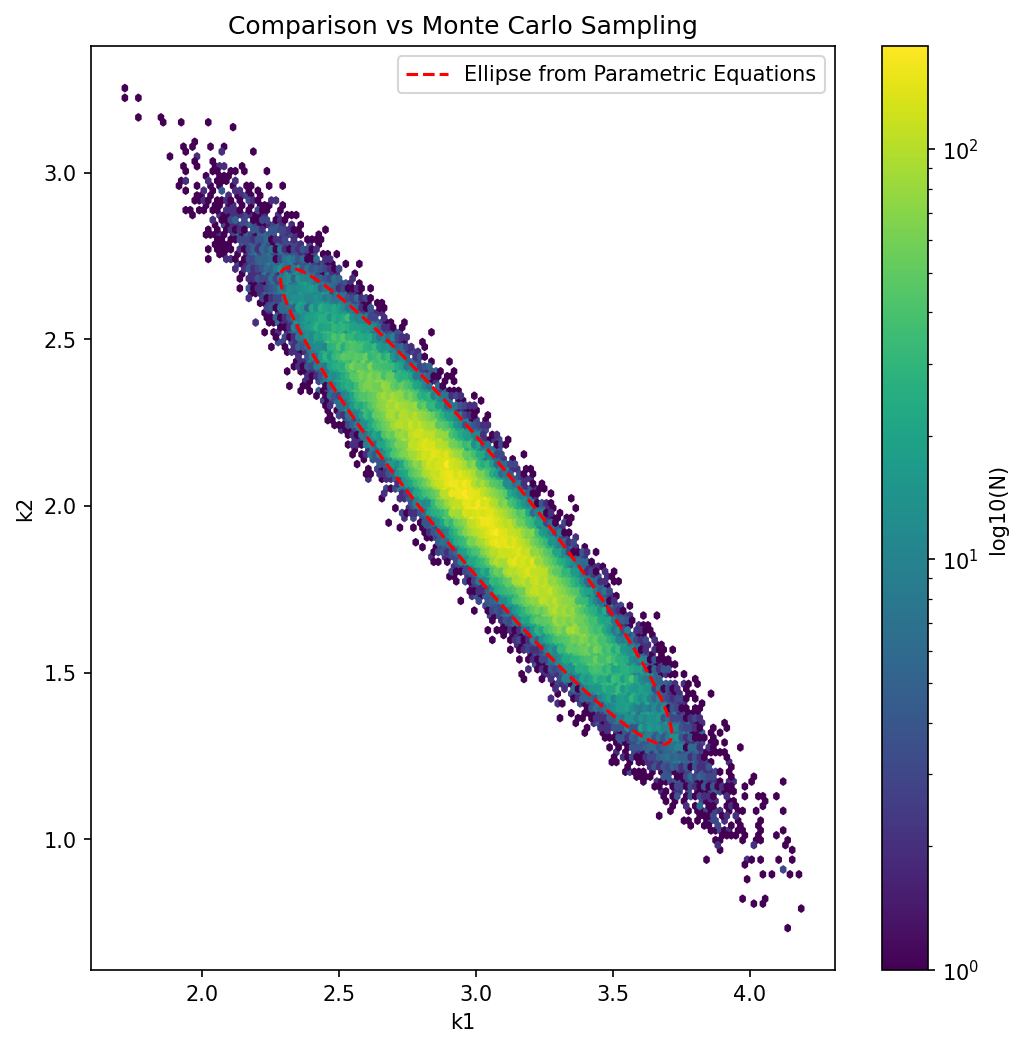

In [8]:
from jax import random


# Set the key for random number generation
key = random.PRNGKey(0)

# Number of simulation points and center of ellipse.
num_simulations = 100000
a, b = 0.15, 1

# Scaling factor for 95% confidence interval in 2D
from scipy.stats import chi2
alpha = 0.95 # Confidence
dof   = 2    # Degrees of freedom
# scaling factor, 2.4477 for 95%
scaling_factor  = np.sqrt(chi2.ppf(alpha, dof))  # take the square root.



# Adjust the a and b values - here a and b are adjusted to be able to build the covariance matrix
# to draw the multivariate normal distribution that will be within 95% of the cloud of points.
a_adjusted = a / scaling_factor
b_adjusted = b / scaling_factor


# Constructing the covariance matrix using a, b, and rotation matrix

covariance_matrix_initial = np.array([[a_adjusted**2,  0],
                                      [0,              b_adjusted**2]])


rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)],
                            [np.sin(phi), np.cos(phi)]])


covariance_matrix_constructed = rotation_matrix @ covariance_matrix_initial @ rotation_matrix.T


# Plotting the ellipses with constructed covariance matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(y1, y2, 'r--', label='Ellipse from Parametric Equations')

# Monte Carlo Sampling simulations
mean = np.array([k1, k2])
samples = random.multivariate_normal(key, mean, covariance_matrix_constructed, (num_simulations,))

hb=ax.hexbin(samples[:, 0], samples[:, 1], gridsize=150, cmap='viridis', bins='log')
fig.colorbar(hb, ax=ax, label='log10(N)')
ax.set_xlabel('k1')
ax.set_ylabel('k2')
ax.set_title('Comparison vs Monte Carlo Sampling')
ax.legend()
plt.show()



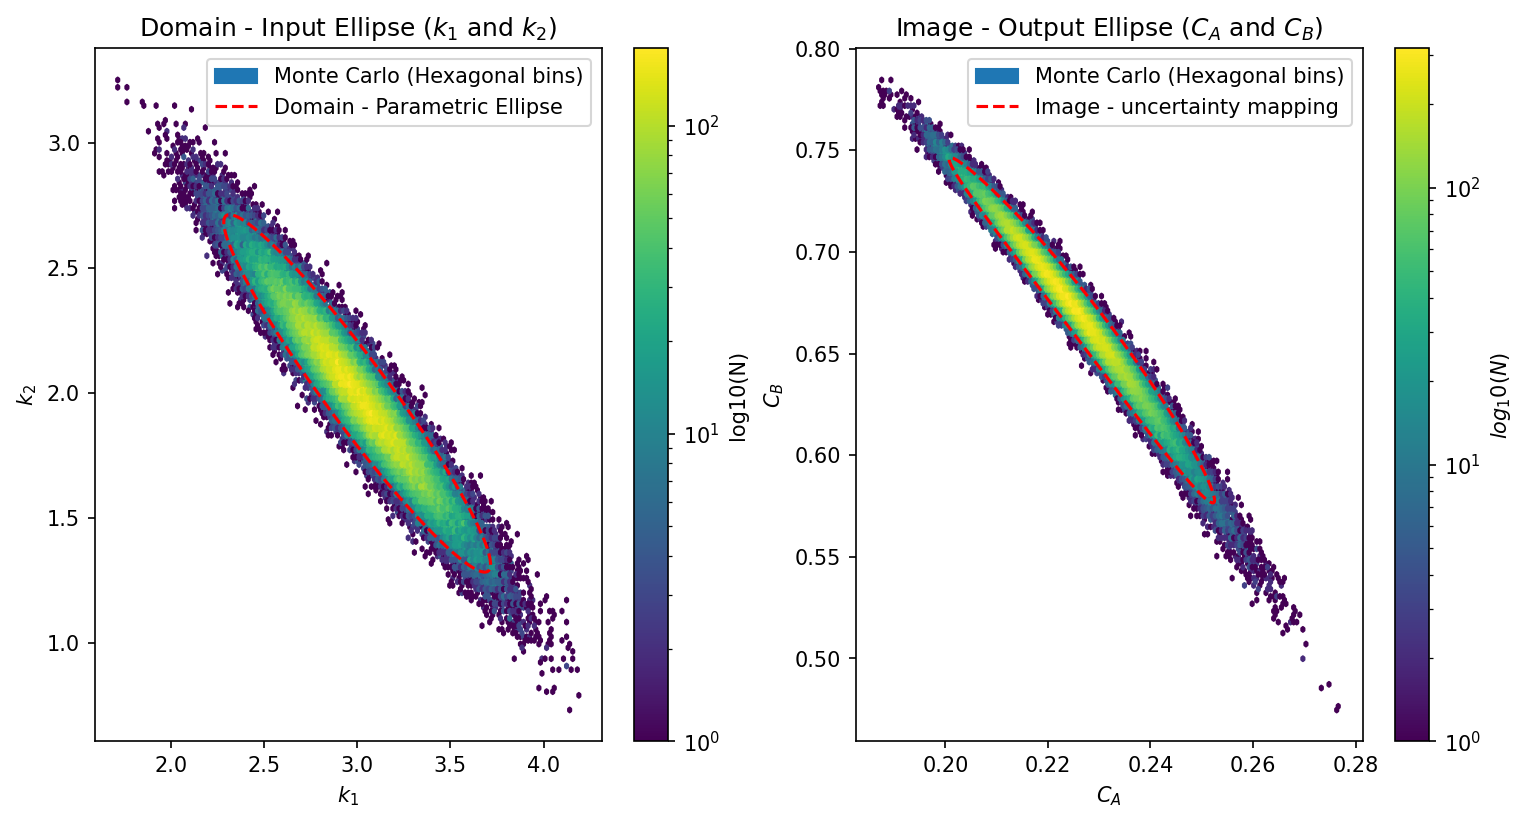

In [9]:
k1_samples = samples[:, 0]
k2_samples = samples[:, 1]


# Calculating Ca and Cb for each Monte Carlo simulation
Ca_values = []
Cb_values = []
for i in range(num_simulations):
    k1 = k1_samples[i]
    k2 = k2_samples[i]

    a, b, c = k2, (v0 / V + k1), -Fa0 / V
    aCa = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    aCb = k1 * aCa * V / v0

    Ca_values.append(aCa)
    Cb_values.append(aCb)

# Plotting the input ellipse for k1 and k2
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(12,6))
hb = ax1.hexbin(k1_samples, k2_samples, gridsize=150, cmap='viridis', bins='log', label='Monte Carlo (Hexagonal bins)')
fig.colorbar(hb, ax=ax1, label='log10(N)')
ax1.plot(AIS_points[:,0], AIS_points[:,1], 'r--', label='Domain - Parametric Ellipse')
ax1.set_title('Domain - Input Ellipse ($k_1$ and $k_2$)')
ax1.set_xlabel('$k_1$')
ax1.set_ylabel('$k_2$')
ax1.legend()

# Plotting the output ellipse for Ca and Cb
hb = ax2.hexbin(Ca_values, Cb_values, gridsize=150, cmap='viridis', bins='log', label='Monte Carlo (Hexagonal bins)')
fig.colorbar(hb, ax=ax2, label='$log_10(N)$')
ax2.plot(AOS_points[1:,0], AOS_points[1:,1],'r--', label='Image - uncertainty mapping')
ax2.set_title('Image - Output Ellipse ($C_A$ and $C_B$)')
ax2.set_xlabel('$C_A$')
ax2.set_ylabel('$C_B$')
ax2.legend()



## Counting points within the ellipse

In [10]:
points =  np.array([Ca_values, Cb_values]).T

points.shape

(100000, 2)

In [11]:
points =  np.array([Ca_values, Cb_values]).T

import matplotlib.path as mpath

path = mpath.Path(AOS_points)

inside_points = path.contains_points(points)

points_in =  np.sum(inside_points)
points_out = len(points) - points_in

print('there are', points_in, 'points within the ellipse')
print('there are', points_out, 'points outside the ellipse')

there are 95022 points within the ellipse
there are 4978 points outside the ellipse


In [12]:
print(points_in/num_simulations * 100, '%')

95.02199999999999 %


$\approx 95\%$ of the points within the elipse.

In [13]:
eigenvalues = ((np.linalg.eig(covariance_matrix_constructed))[0])

eigenvalues = np.sqrt(eigenvalues.real*(scaling_factor**2))

print(eigenvalues)

[0.15 1.  ]


0.15 and 1 as we defined in the parametric equations initially.